In [59]:
import os
import zipfile
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import cv2

### Extracting data

In [2]:
url = "https://github.com/srihari-humbarwadi/datasets/releases/download/v0.1.0/data.zip"
filename = os.path.join(os.getcwd(), "data.zip")
keras.utils.get_file(filename, url)


with zipfile.ZipFile("data.zip", "r") as z_fp:
    z_fp.extractall("./")


### utilities

In [134]:
def convert_to_xywh(boxes): 
    '''
        Convert boxes with corner coordinates to xywh coordinates
        
        Arguments: 
            boxes: Tensor of size (num_boxes,4) 
    '''
    print(tf.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3], boxes[:,2]], axis=-1))
    return tf.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3] - boxes[:, 1], boxes[:,2] - boxes[:,0]], axis=-1)


def scale_bbox(boxes, image_shape): 
    
    '''
        Scale boxes with format xywh
    '''
    
    y_scale = image_shape[0]
    x_scale = image_shape[1] 
    return tf.stack([boxes[:, 0] * x_scale, boxes[:, 1] * y_scale, boxes[:, 2] * x_scale, boxes[:,3] * y_scale], axis=-1)


def convert_to_corner(boxes): 
    
    
    '''
        concert a batch of (xmin, ymin, w, h) boxes to (xmin, ymin, xmax, ymax)
    '''
    
    return tf.stack([boxes[:,0], boxes[:,1], boxes[:,0] + boxes[:,2], boxes[:,1] + boxes[:,3]], axis=-1)

In [56]:
(train_dataset, val_dataset), dataset_info = tfds.load(
    "coco/2017", split=["train", "validation"], with_info=True, data_dir="data"
)

autotune = tf.data.experimental.AUTOTUNE
train_dataset

<PrefetchDataset shapes: {image: (None, None, 3), image/filename: (), image/id: (), objects: {area: (None,), bbox: (None, 4), id: (None,), is_crowd: (None,), label: (None,)}}, types: {image: tf.uint8, image/filename: tf.string, image/id: tf.int64, objects: {area: tf.int64, bbox: tf.float32, id: tf.int64, is_crowd: tf.bool, label: tf.int64}}>

### let's visualize some samples

tf.Tensor(460139, shape=(), dtype=int64)
image shape  (462, 640, 3)
bobxs shape  (3, 4)
lables shape , (3,)
tf.Tensor(
[[0.13464062 0.54380953 0.33742186 0.98651516]
 [0.517875   0.50707793 0.891125   0.8044805 ]
 [0.36971876 0.3264935  0.4431875  0.65203464]], shape=(3, 4), dtype=float32)
xywh bboxl tf.Tensor(
[[0.13464062 0.54380953 0.20278125 0.44270563]
 [0.517875   0.50707793 0.37325    0.29740256]
 [0.36971876 0.3264935  0.07346874 0.32554114]], shape=(3, 4), dtype=float32)
corners tf.Tensor(
[[0.13464062 0.54380953 0.33742186 0.98651516]
 [0.517875   0.50707793 0.891125   0.8044805 ]
 [0.36971876 0.3264935  0.4431875  0.65203464]], shape=(3, 4), dtype=float32)


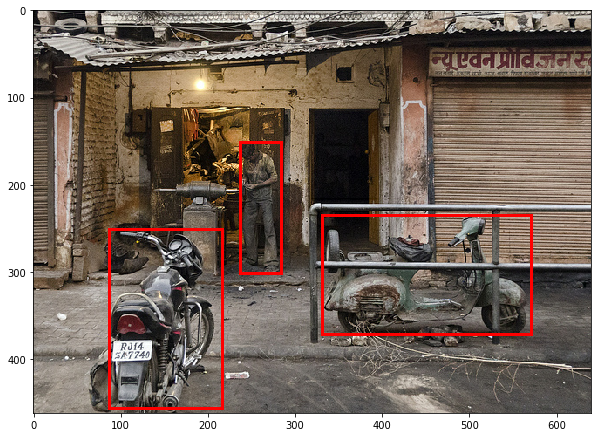

In [133]:
batch = train_dataset.take(1)

for idx, sample in enumerate(batch): 
    print(sample["image/id"])
    image = sample["image"]
    print("image shape ", image.shape)
    bboxs = sample["objects"]["bbox"]
    print("bobxs shape ", bboxs.shape)
    labels = sample["objects"]["label"]
    print("lables shape ,", labels.shape)
    plt.figure(figsize=(10,10)) 
    plt.imshow(image)
    ax = plt.gca()
    bboxs = convert_to_xywh(bboxs) 
    bboxs = scale_bbox(bboxs, (image.shape[0], image.shape[1]))
    for bbox, label in zip(bboxs, labels): 
        rect = plt.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3],linewidth=3,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
    break


In [97]:
class ROI: 
    
    '''
        class responsible for generating ROI using Selective Search
        ROI's shapes : x, y, w, h
    '''
    
    
    def __init__(self, resize_width=96, resize_height=96): 
        self.height = resize_width 
        self.width = resize_height
        
    def generate_roi(self, image, roi_nb): 
        '''
            return roi_nb ROI for the image of shape : x, y, w, h
            Arguments: 
                image : the actual sample image 
                roi_nb : the number of roi to extract from the image
        '''
        
        ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
        ss.setBaseImage(image)
        ss.switchToSelectiveSearchFast()
        rects = ss.process()[:roi_nb]
        
        return tf.stack([rects[:,0], rects[:,1], rects[:,2], rects[:,3]], axis=-1)

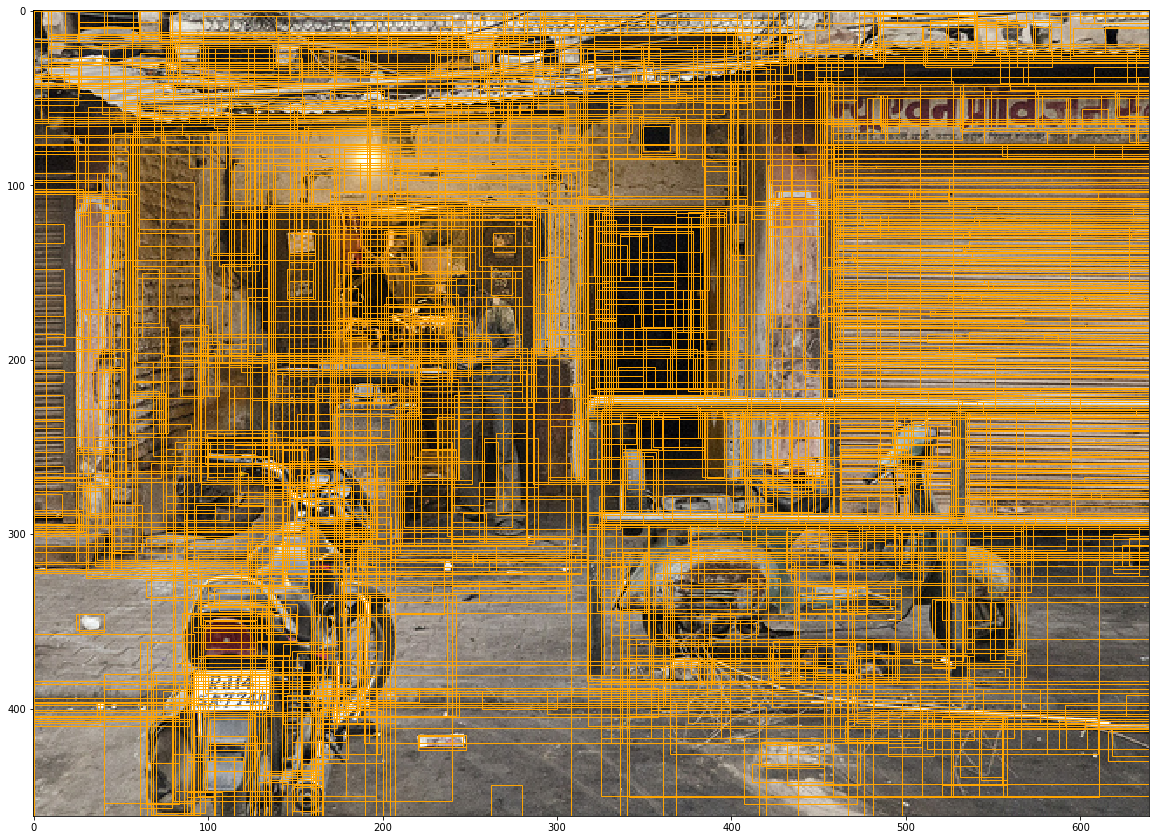

In [108]:
# for sample in batch: 
#     image = sample["image"].numpy()
#     break


# roi = ROI()
# all_rois = roi.get_roi(image,2000)

# plt.figure(figsize=(20,20))
# plt.imshow(image)
# ax = plt.gca()
# for roi in all_rois: 
#     single_roi = roi.numpy()
#     rect = plt.Rectangle((single_roi[0], single_roi[1]), single_roi[2], single_roi[3],linewidth=1,edgecolor='orange',facecolor='none')
#     ax.add_patch(rect)


In [ ]:
def compute_iou(rois, boxes): 
    
    '''
        compute the pairwise IOU between rois and boxes and return a matrix of all iou score 
        where the coefficient (ith,jth) of the ith row, jth colomun is the iou score between the ith roi and jth boxe
    '''
    
    # convert all boxes and rois to corner coordinates
    rois = convert_to_corner(rois) 
    boxes = convert_to_corner(boxes)
    
    
    
    # getting minmum coordinates
    
    
    

In [148]:
a = np.random.randn(2,4) 
print(a) 
print()
b = np.random.randn(2,4) 
print(b)

[[-1.01995776 -1.29921962 -0.69480785 -1.16600109]
 [-1.27583616 -2.35770762  0.91579396  0.09366866]]

[[-0.20669489 -1.26862643 -0.46464624 -0.34552323]
 [-1.00470022 -0.2268476  -1.28707654  1.04727245]]


In [169]:
c,d, e, f = tf.split(b, num_or_size_splits=4, axis=1)
tf.minimum(c, e)

<tf.Tensor: shape=(2, 1), dtype=float64, numpy=
array([[-0.46464624],
       [-1.28707654]])>

In [ ]:
class LabelEncoder: 
    
    '''        This class has operations to generate targets for a batch of samples which
        is made up of the input images, bounding boxes for the objects present and
        their class ids.
    '''
    
    def __init__(self): 
        roi = ROI()
        
    def _match_roi_boxes(self, rois, gt_boxes, match_iou=0.5, ignore_iou=0.4): 
        
        '''
            Matches ground truth boxes to rois boxes based on IOU
        '''
        
    
    